In [1]:
import tensorflow as tf
from tensorflow.python.keras.backend import set_session
import os
import csv
import random
import numpy as np

import time
 
from tqdm import tqdm 

from PIL import Image
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold

from tensorflow.keras import backend as K

2025-03-25 13:33:13.725835: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-25 13:33:13.725873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-25 13:33:13.726521: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-25 13:33:13.730393: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-25 13:33:14.448241: W tensorflow/compiler/tf2

In [2]:
num_classes = 1
k = 5


IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

DATA_PATH = 'data/'

data_ids = next(os.walk(DATA_PATH+'/image'))[2]

X = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

# Definição do diretório de saída
output_dir = "Trans UNet DA DICE 5-fold model"
os.makedirs(output_dir, exist_ok=True)  # Garante que a pasta existe

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR']= 'cuda_malloc_async'


In [3]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(data_ids), total=len(data_ids)):   
    path = DATA_PATH
    img = imread(path + '/image/' + id_)[:,:]
    img = img.reshape(img.shape[0], img.shape[1], IMG_CHANNELS)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img  #Fill empty X_train with values from img
    
    mask = imread(path + 'label/' + id_)
    mask = (mask >= 250)
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
    y[n] = mask 
    #plt.axis("off")
    #imshow(y[n])
    #plt.show()

Resizing training images and masks


100%|█████████████████████████████████████████████████████████████████████████████████| 838/838 [00:19<00:00, 43.80it/s]


In [4]:
# Create ImageDataGenerator for Data Augmentation
data_genX = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=2.5,
    width_shift_range=0.075,
    height_shift_range=0.075,
    shear_range=0.075,
    zoom_range=0.075,
    horizontal_flip=True,
)

In [5]:
# Create ImageDataGenerator for Data Augmentation
data_genY = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=2.5,
    width_shift_range=0.075,
    height_shift_range=0.075,
    shear_range=0.075,
    zoom_range=0.075,
    horizontal_flip=True,
)

In [6]:
# Generate additional images to equalize classes if necessary
def generate(X_all, y_all):

# Generation
    X_generated = []
    y_generated = []
    
    data_gen.fit(X_all)
    
    generated_images = data_gen.flow(X_all, y_all, batch_size=1)
    
    for _ in range(len(X_all)):
        X_new, y_new = next(generated_images)
        X_generated.append(np.squeeze(X_new))
        y_generated.append(np.squeeze(y_new))

    print(f'New images generated: {len(X_generated)}')

    return X_generated, y_generated

In [7]:
def plot_images(images, images_per_figure=100):
    num_images = len(images)
    cols = 5
    rows = (images_per_figure + cols - 1) // cols

    for start in range(0, num_images, images_per_figure):
        plt.figure(figsize=(cols * 3, rows * 3))
        end = min(start + images_per_figure, num_images)

        for i in range(start, end):
            plt.subplot(rows, cols, i - start + 1)
            plt.imshow(images[i])
            plt.axis('off')

        plt.tight_layout()
        plt.show()

In [8]:
@tf.keras.utils.register_keras_serializable()
def f1_score(y_true, y_pred):
    """Calcula o F1-Score para segmentação binária"""
    y_pred = K.round(y_pred)  # Arredondar para 0 ou 1
    tp = K.sum(K.cast(y_true * y_pred, 'float32'))  # Verdadeiros Positivos
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float32'))  # Falsos Positivos
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float32'))  # Falsos Negativos
    
    precision = tp / (tp + fp + K.epsilon())  # Precision
    recall = tp / (tp + fn + K.epsilon())  # Recall
    
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())  # F1-Score
    return f1

In [9]:
@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))


In [10]:
from tensorflow.keras.layers import (
    Conv2D, Dropout, BatchNormalization, ReLU, MaxPooling2D,
    Conv2DTranspose, Concatenate, Reshape, Dense, LayerNormalization,
    MultiHeadAttention, Input
)
from tensorflow.keras.models import Model

@tf.keras.utils.register_keras_serializable()
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, num_patches, d_model):
        super(PositionalEmbedding, self).__init__()
        self.pos_emb = self.add_weight(
            shape=(1, num_patches, d_model),
            initializer='zeros',
            trainable=True,
            name='positional_embedding'
        )

    def call(self, inputs):
        return inputs + self.pos_emb

def trans_unet():
    input_shape =  (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    inputs = Input(input_shape)
    
    def conv_block(x, filters, dropout=0.1):
        x = Conv2D(filters, (3, 3), activation='relu', 
                 kernel_initializer='he_normal', padding='same')(x)
        x = Dropout(dropout)(x)
        x = Conv2D(filters, (3, 3), activation='relu', 
                 kernel_initializer='he_normal', padding='same')(x)
        x = BatchNormalization()(x)
        return ReLU()(x)
    
    # Encoder (CNN)
    c1 = conv_block(inputs, 16)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = conv_block(p1, 32)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = conv_block(p2, 64, dropout=0.2)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = conv_block(p3, 128, dropout=0.2)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Transformer Bottleneck
    h = input_shape[0] // 16
    w = input_shape[1] // 16
    num_patches = h * w
    d_model = 256
    
    x = Reshape((num_patches, 128))(p4)
    x = Dense(d_model)(x)
    x = PositionalEmbedding(num_patches, d_model)(x)
    
    # Transformer Encoder
    num_heads = 8
    for _ in range(4):
        x1 = LayerNormalization()(x)
        attn = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(x1, x1)
        x = attn + x
        x2 = LayerNormalization()(x)
        mlp = Dense(d_model * 4, activation='gelu')(x2)
        mlp = Dense(d_model)(mlp)
        x = mlp + x
    
    x = Reshape((h, w, d_model))(x)
    
    # Decoder (UNet++ style)
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    u6 = Concatenate()([u6, c4])
    c6 = conv_block(u6, 128)
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = Concatenate()([u7, c3])
    c7 = conv_block(u7, 64)
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = Concatenate()([u8, c2])
    c8 = conv_block(u8, 32)
    
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = Concatenate()([u9, c1])
    c9 = conv_block(u9, 16)
    
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss=dice_loss, metrics=[
        'accuracy', 
        tf.keras.metrics.Recall(name='recall'), 
        tf.keras.metrics.Precision(name='precision'),
        f1_score,
        tf.keras.metrics.IoU(num_classes=2, target_class_ids={0,1}, name='IoU')
    ])
    
    return model


In [11]:
acc = []
jacc = []
f1 = []
prec = []
rec = []

# Dicionário para armazenar métricas por fold
fold_metrics_summary = []
seed = [42, 21, 5, 10, 72]

kf = KFold(n_splits=k, shuffle=True, random_state=28)
fold = 3

for i, (train_ind, test_ind) in enumerate(kf.split(X)):
    if i < (fold-1):
        continue
    
    
    print("Fold: " + str(fold))
    X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]

    model = trans_unet()
    
    
    checkpoint_filepath = os.path.join(output_dir, f'model_{fold}fold.keras')
    callbacks = [
            tf.keras.callbacks.TensorBoard(log_dir='logs'),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=False,
                monitor='val_f1_score',
                mode='max',
                save_best_only=True,
                verbose=1)]
    
    image_generator = data_genX.flow(X_train, batch_size=16, seed=seed[fold-1])
    mask_generator = data_genY.flow(y_train, batch_size=16, seed=seed[fold-1])
    
    # Criar um gerador que produza (imagem, máscara) no mesmo passo
    train_generator = zip(image_generator, mask_generator)
    
    start_time = time.time()
    model.fit(train_generator, steps_per_epoch=len(X_train) // 16, validation_data=(X_val,y_val), epochs=150, callbacks=callbacks, class_weight={0:1.0, 1:100.0})
    end_time = time.time()
    training_time = end_time - start_time

     # Salvando o tempo de treinamento
    with open(os.path.join(output_dir, 'training_time.txt'), 'a') as f:
        f.write(f'Fold {fold}: {training_time:.2f} segundos\n')
    print(f"O modelo demorou {training_time:.2f} segundos para treinar.")
    
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    
    with open(os.path.join(output_dir, f'loss_fold{fold}.csv'), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(["Epoch", "Loss", "Validation Loss"])
        for epoch, (l, vl) in enumerate(zip(loss, val_loss), start=1):
            writer.writerow([epoch, l, vl])
            
     # Plotando e salvando a figura
    plt.figure()
    plt.plot(loss, 'r', label='Training loss')
    plt.plot(val_loss, 'g', label='Validation loss')
    plt.title(f'Training and Validation Loss - Fold {fold}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.ylim([0, 1])
    plt.legend()
    plt.savefig(os.path.join(output_dir, f'loss_plot_fold{fold}.png'))
    plt.close()


    fold_metrics = []

    acc_fold = []
    jacc_fold = []
    f1_fold = []
    prec_fold = []
    rec_fold = []
    
    for i in range(0, len(X_val)):
        sample_image = X_val[i]
        sample_mask = y_val[i].astype(np.uint8).flatten()
        prediction = model.predict(sample_image[tf.newaxis, ...],verbose=0)[0]
        predicted_mask = (prediction > 0.5).astype(np.uint8).flatten()
            
        acc_score = accuracy_score(sample_mask, predicted_mask)
        jacc_score = jaccard_score(sample_mask, predicted_mask)
        f1_score_val = f1_score(sample_mask, predicted_mask).numpy()
        prec_score = precision_score(sample_mask, predicted_mask)
        rec_score = recall_score(sample_mask, predicted_mask)

        acc_fold.append(acc_score)
        jacc_fold.append(jacc_score)
        f1_fold.append(f1_score_val)
        prec_fold.append(prec_score)
        rec_fold.append(rec_score)

        fold_metrics.append([i, acc_score, jacc_score, f1_score_val, prec_score, rec_score])
        
    # Salvando métricas por imagem
    with open(os.path.join(output_dir, f'metrics_fold{fold}.csv'), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(["Index", "Accuracy", "Jaccard", "DICE", "Precision", "Recall"])
        writer.writerows(fold_metrics)

    # Salvando a média do fold para cada métrica
    fold_metrics_summary.append([
        fold, np.mean(acc_fold), np.std(acc_fold),
        np.mean(jacc_fold), np.std(jacc_fold),
        np.mean(f1_fold), np.std(f1_fold),
        np.mean(prec_fold), np.std(prec_fold),
        np.mean(rec_fold), np.std(rec_fold)
    ])

        
    del model 

    tf.keras.backend.clear_session()

    fold+=1
    
# Calculando médias gerais
acc_total = [m[1] for m in fold_metrics_summary]
jacc_total = [m[3] for m in fold_metrics_summary]
f1_total = [m[5] for m in fold_metrics_summary]
prec_total = [m[7] for m in fold_metrics_summary]
rec_total = [m[9] for m in fold_metrics_summary]

general_summary = [
    ["Fold", "Accuracy Mean", "Accuracy Std", "Jaccard Mean", "Jaccard Std",
     "DICE Mean", "DICE Std", "Precision Mean", "Precision Std", "Recall Mean", "Recall Std"]
]

general_summary.extend(fold_metrics_summary)

general_summary.append([
    "Overall Mean", np.mean(acc_total), np.std(acc_total),
    np.mean(jacc_total), np.std(jacc_total),
    np.mean(f1_total), np.std(f1_total),
    np.mean(prec_total), np.std(prec_total),
    np.mean(rec_total), np.std(rec_total)
])

# Salvando o resumo das métricas por fold e geral
with open(os.path.join(output_dir, 'metrics_summary.csv'), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';')
    writer.writerows(general_summary)

print("Métricas salvas com sucesso na pasta:", output_dir)

Fold: 3


2025-03-25 13:33:35.375236: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-25 13:33:35.403728: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-25 13:33:35.403767: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-25 13:33:35.405403: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-25 13:33:35.405432: I external/local_xla/xla/stream_executor

Epoch 1/150


2025-03-25 13:33:40.622031: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-03-25 13:33:41.289028: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-03-25 13:33:45.144081: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 1828790272 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 1340080128/12878086144
2025-03-25 13:33:45.144126: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                     10022289408
InUse:                      9669073826
MaxInUse:                  10491175858
NumAllocs:                        1626
MaxAllocSize:               2722250752
Reserved:   

41/41 [==============================] - ETA: 0s - loss: 1.0589 - accuracy: 0.6695 - recall: 0.9991 - precision: 0.0024 - f1_score: 0.0043 - IoU: 0.4972
Epoch 1: val_f1_score improved from -inf to 0.00187, saving model to Trans UNet DA DICE 5-fold model/model_3fold.keras
41/41 [==============================] - 64s 699ms/step - loss: 1.0589 - accuracy: 0.6695 - recall: 0.9991 - precision: 0.0024 - f1_score: 0.0043 - IoU: 0.4972 - val_loss: 0.9982 - val_accuracy: 0.3923 - val_recall: 1.0000 - val_precision: 0.0010 - val_f1_score: 0.0019 - val_IoU: 0.2892
Epoch 2/150
41/41 [==============================] - ETA: 0s - loss: 1.0589 - accuracy: 0.9405 - recall: 0.9944 - precision: 0.0134 - f1_score: 0.0276 - IoU: 0.5148
Epoch 2: val_f1_score improved from 0.00187 to 0.07518, saving model to Trans UNet DA DICE 5-fold model/model_3fold.keras
41/41 [==============================] - 40s 490ms/step - loss: 1.0589 - accuracy: 0.9405 - recall: 0.9944 - precision: 0.0134 - f1_score: 0.0276 - IoU: 

2025-03-25 14:24:50.993761: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


41/41 [==============================] - ETA: 0s - loss: 1.0590 - accuracy: 0.7862 - recall: 0.9101 - precision: 0.0034 - f1_score: 0.0056 - IoU: 0.5007
Epoch 1: val_f1_score improved from -inf to 0.00163, saving model to Trans UNet DA DICE 5-fold model/model_4fold.keras
41/41 [==============================] - 32s 561ms/step - loss: 1.0590 - accuracy: 0.7862 - recall: 0.9101 - precision: 0.0034 - f1_score: 0.0056 - IoU: 0.5007 - val_loss: 0.9982 - val_accuracy: 0.3624 - val_recall: 1.0000 - val_precision: 9.1653e-04 - val_f1_score: 0.0016 - val_IoU: 0.1969
Epoch 2/150
41/41 [==============================] - ETA: 0s - loss: 1.0515 - accuracy: 0.9814 - recall: 0.9511 - precision: 0.0408 - f1_score: 0.0774 - IoU: 0.5467
Epoch 2: val_f1_score improved from 0.00163 to 0.02149, saving model to Trans UNet DA DICE 5-fold model/model_4fold.keras
41/41 [==============================] - 43s 500ms/step - loss: 1.0515 - accuracy: 0.9814 - recall: 0.9511 - precision: 0.0408 - f1_score: 0.0774 - I

/home/mbouzon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mbouzon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mbouzon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mbouzon/.local/lib/python3.10/site-pa

Fold: 5
Epoch 1/150


2025-03-25 15:20:35.382259: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


41/41 [==============================] - ETA: 0s - loss: 1.0599 - accuracy: 0.7245 - recall: 0.9889 - precision: 0.0029 - f1_score: 0.0050 - IoU: 0.5140
Epoch 1: val_f1_score improved from -inf to 0.00129, saving model to Trans UNet DA DICE 5-fold model/model_5fold.keras
41/41 [==============================] - 39s 722ms/step - loss: 1.0599 - accuracy: 0.7245 - recall: 0.9889 - precision: 0.0029 - f1_score: 0.0050 - IoU: 0.5140 - val_loss: 0.9986 - val_accuracy: 0.1733 - val_recall: 1.0000 - val_precision: 7.2069e-04 - val_f1_score: 0.0013 - val_IoU: 0.2142
Epoch 2/150
41/41 [==============================] - ETA: 0s - loss: 1.0587 - accuracy: 0.9631 - recall: 0.9883 - precision: 0.0215 - f1_score: 0.0446 - IoU: 0.5242
Epoch 2: val_f1_score improved from 0.00129 to 0.00156, saving model to Trans UNet DA DICE 5-fold model/model_5fold.keras
41/41 [==============================] - 30s 733ms/step - loss: 1.0587 - accuracy: 0.9631 - recall: 0.9883 - precision: 0.0215 - f1_score: 0.0446 - I

In [12]:
acc_mean_fold = []
jacc_mean_fold = []
f1_mean_fold = []
prec_mean_fold = []
rec_mean_fold = []

acc_std_fold = []
jacc_std_fold = []
f1_std_fold = []
prec_std_fold = []
rec_std_fold = []


# Dicionário para armazenar métricas por fold
fold_metrics_summary = []

fold = 1
kf = KFold(n_splits=k, shuffle=True, random_state=28)
for train_ind, test_ind in tqdm(kf.split(X), total=kf.get_n_splits(), desc="k-fold"):
    X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]

    fold_metrics = []

    acc_fold = []
    jacc_fold = []
    f1_fold = []
    prec_fold = []
    rec_fold = []
    
    model_filepath = filepath = os.path.join(output_dir, f'model_{fold}fold.keras')
    model = tf.keras.models.load_model(model_filepath)

    for i in range(0, len(X_val)):
        sample_image = X_val[i]
        sample_mask = y_val[i].astype(np.uint8).flatten()
        prediction = model.predict(sample_image[tf.newaxis, ...],verbose=0)[0]
        predicted_mask = (prediction > 0.5).astype(np.uint8).flatten()
            
        acc_score = accuracy_score(sample_mask, predicted_mask)
        jacc_score = jaccard_score(sample_mask, predicted_mask)
        f1_score_val = f1_score(sample_mask, predicted_mask).numpy()
        prec_score = precision_score(sample_mask, predicted_mask)
        rec_score = recall_score(sample_mask, predicted_mask)

        acc_fold.append(acc_score)
        jacc_fold.append(jacc_score)
        f1_fold.append(f1_score_val)
        prec_fold.append(prec_score)
        rec_fold.append(rec_score)

        fold_metrics.append([i, acc_score, jacc_score, f1_score_val, prec_score, rec_score])
        
    # Salvando métricas por imagem
    with open(os.path.join(output_dir, f'metrics_fold{fold}.csv'), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(["Index", "Accuracy", "Jaccard", "DICE", "Precision", "Recall"])
        writer.writerows(fold_metrics)

    # Salvando a média do fold para cada métrica
    fold_metrics_summary.append([
        fold, np.mean(acc_fold), np.std(acc_fold),
        np.mean(jacc_fold), np.std(jacc_fold),
        np.mean(f1_fold), np.std(f1_fold),
        np.mean(prec_fold), np.std(prec_fold),
        np.mean(rec_fold), np.std(rec_fold)
    ])


    fold += 1

# Calculando médias gerais
acc_total = [m[1] for m in fold_metrics_summary]
jacc_total = [m[3] for m in fold_metrics_summary]
f1_total = [m[5] for m in fold_metrics_summary]
prec_total = [m[7] for m in fold_metrics_summary]
rec_total = [m[9] for m in fold_metrics_summary]

general_summary = [
    ["Fold", "Accuracy Mean", "Accuracy Std", "Jaccard Mean", "Jaccard Std",
     "DICE Mean", "DICE Std", "Precision Mean", "Precision Std", "Recall Mean", "Recall Std"]
]

general_summary.extend(fold_metrics_summary)

general_summary.append([
    "Overall Mean", np.mean(acc_total), np.std(acc_total),
    np.mean(jacc_total), np.std(jacc_total),
    np.mean(f1_total), np.std(f1_total),
    np.mean(prec_total), np.std(prec_total),
    np.mean(rec_total), np.std(rec_total)
])

# Salvando o resumo das métricas por fold e geral
with open(os.path.join(output_dir, 'metrics_summary.csv'), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';')
    writer.writerows(general_summary)

print("Métricas salvas com sucesso na pasta:", output_dir)

k-fold:  20%|███████████████▍                                                             | 1/5 [00:52<03:30, 52.66s/it]/home/mbouzon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
k-fold:  40%|██████████████████████████████▊                                              | 2/5 [01:44<02:36, 52.29s/it]/home/mbouzon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mbouzon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precisi

Métricas salvas com sucesso na pasta: Trans UNet DA DICE 5-fold model


In [13]:
print("Accuracy: "+ str(np.mean(acc_total)*100) + " +- " + str(np.std(acc_total)*100))
print("Jaccard: "+ str(np.mean(jacc_total)*100) + " +- " + str(np.std(jacc_total)*100))
print("Dice: "+ str(np.mean(f1_total)*100) + " +- " + str(np.std(f1_total)*100))
print("Precision: "+ str(np.mean(prec_total)*100) + " +- " + str(np.std(prec_total)*100))
print("Recall: "+ str(np.mean(rec_total)*100) + " +- " + str(np.std(rec_total)*100))

Accuracy: 99.99614474370263 +- 0.0012972443067728466
Jaccard: 92.03109410821396 +- 1.2770914786758358
Dice: 95.358407497406 +- 0.8853478357195854
Precision: 96.082425657405 +- 0.44529877249365807
Recall: 95.35812684526776 +- 1.27817579024535


In [14]:
best_fold = 2
best_model_filepath = filepath = os.path.join(output_dir, f'model_{best_fold}fold.keras')
best_model = tf.keras.models.load_model(best_model_filepath)

In [15]:
kf = KFold(n_splits=k, shuffle=True, random_state=28)
for i, (train_ind, test_ind) in enumerate(kf.split(X)):
    if i == (best_fold-1):
        X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]
        break

In [16]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input image', 'True mask', 'Predicted mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='gray')
    plt.axis('off')
  plt.show()


1/1 [==============================] - 0s 120ms/step


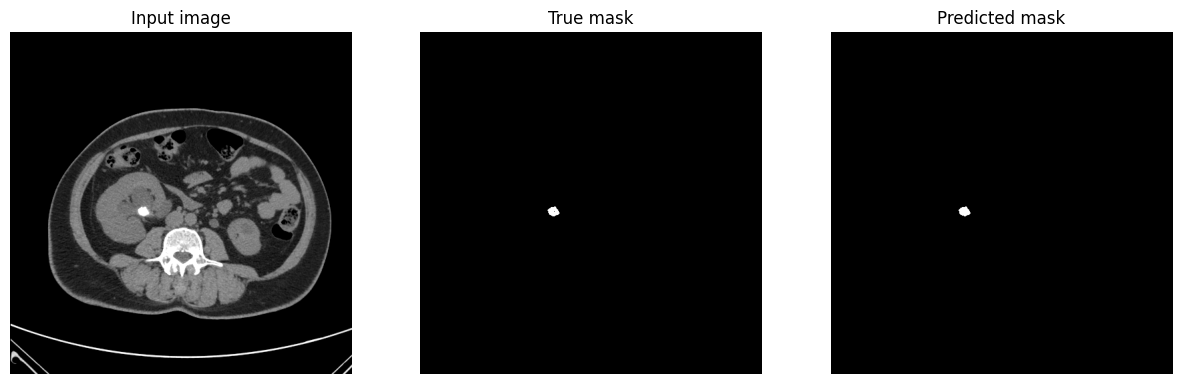

Accuracy: 0.9999847412109375
Jaccard: 0.9782608695652174
Dice: 0.989010989010989
Precision: 0.9836065573770492
Recall: 0.994475138121547


In [18]:
i = random.randint(0, len(X_val))
#i = 155
sample_image = X_val[i]
sample_mask = y_val[i]
prediction = best_model.predict(sample_image[tf.newaxis, ...])[0]
predicted_mask = (prediction > 0.5).astype(np.uint8)
display([sample_image, sample_mask,predicted_mask])

sample_mask = y_val[i].astype(np.uint8).flatten()
predicted_mask = predicted_mask.flatten()


print("Accuracy: "+ str(accuracy_score(sample_mask, predicted_mask)))
print("Jaccard: "+ str(jaccard_score(sample_mask, predicted_mask)))
print("Dice: "+ str((2*jaccard_score(sample_mask, predicted_mask))/(1+jaccard_score(sample_mask, predicted_mask))))
print("Precision: "+ str(precision_score(sample_mask, predicted_mask)))
print("Recall: "+ str(recall_score(sample_mask, predicted_mask)))